# COMP3314 HW3: Image Classification

In this project, you could use all the techniques that you learn from this course **(except CNNs)**  to construct an image classifier for the given dataset. You are required to complete the tasks in the following three sections to prepare the dataset, build your classifier, and submit your predictions on the test set.

Important notes:
- TAs will run the code to check the final results. Please make the code executable and keep your executed outputs. If TAs find the executed result does not match the final submission, this submission will receive 0 points.
- Do not use convolutional neural networks (CNNs) in this project.
- Make sure to submit the file in the specified format. Otherwiser, our autograder will not be able to verify your results.
- Do not use any additional datasets or pretrained networks in this project. Do not copy the code or prediction results from others.

## Section 0. Download dataset.

In [2]:
import cv2
import os
import random
import numpy as np
from pathlib import Path
import urllib.request
import zipfile
import urllib
import hashlib
from tqdm import tqdm

random.seed(0)
np.random.seed(0)

In [3]:
def download_data(data_dir):
    """
    DO NOT modify the code in this cell.
    
    Args:
        data_dir (Path): Path to the download and extract data directory.

    Returns:
        xs_train: (num_train, 32, 32, 3) uint8
        ys_train: (num_train, ) uint8
        xs_test: (num_test, 32, 32, 3) uint8
    """

    class DownloadProgressBar(tqdm):

        def update_to(self, b=1, bsize=1, tsize=None):
            if tsize is not None:
                self.total = tsize
            self.update(b * bsize - self.n)

    def compute_md5(file_path):
        file_path = Path(file_path)
        if not file_path.is_file():
            raise ValueError(f"File {file_path} does not exist.")

        with open(file_path, "rb") as f:
            file_hash = hashlib.md5()
            chunk = f.read(8192)
            while chunk:
                file_hash.update(chunk)
                chunk = f.read(8192)

        return str(file_hash.hexdigest())

    def maybe_download_url(url, output_path, md5sum=None):
        output_path = Path(output_path)

        if output_path.is_file() and md5sum is not None:
            if compute_md5(output_path) == md5sum:
                print(f"{output_path} exists and MD5 matches. Skip download.")
                return

        with DownloadProgressBar(unit='B',
                                 unit_scale=True,
                                 miniters=1,
                                 desc=url.split('/')[-1]) as t:
            urllib.request.urlretrieve(url,
                                       filename=output_path,
                                       reporthook=t.update_to)

    # Paths
    data_dir = Path(data_dir)
    data_dir.mkdir(parents=True, exist_ok=True)
    zip_path = data_dir / "data.zip"
    url = "https://github.com/comp3314/hw3-data/releases/download/hw3/data.zip"
    md5sum = "bd4f13ea7b8d9b79c1320fe559698dbd"

    # Download URL
    maybe_download_url(url, zip_path, md5sum=md5sum)

    # Extract zip
    print("Extracting...")
    with zipfile.ZipFile(zip_path, 'r') as f:
        f.extractall(data_dir)
    print("Extracting done.")


def load_data(data_dir):
    data_dir = Path(data_dir)
    if not data_dir.is_dir():
        raise ValueError(f"{data_dir} is not a directory.")

    # Read train
    train_dir = data_dir / "train"
    train_label_path = train_dir / "labels.txt"
    xs_train = []
    ys_train = []
    with open(train_label_path, "r") as f:
        lines = f.readlines()
        lines = [line.strip() for line in lines]
    for line in tqdm(lines, desc="Read train"):
        im_path, im_label = line.split(" ")
        im_path = train_dir / im_path
        im_bgr = cv2.imread(str(im_path))
        im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)
        assert im_rgb.shape == (32, 32, 3)
        assert im_rgb.dtype == np.uint8
        xs_train.append(im_rgb)
        ys_train.append(int(im_label))

    # Read test
    test_dir = data_dir / "test"
    test_label_path = test_dir / "labels.txt"
    xs_test = []
    with open(test_label_path, "r") as f:
        lines = f.readlines()
        lines = [line.strip() for line in lines]
    for line in tqdm(lines, desc="Read test"):
        im_path = line
        im_path = test_dir / im_path
        im_bgr = cv2.imread(str(im_path))
        im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)
        assert im_rgb.shape == (32, 32, 3)
        assert im_rgb.dtype == np.uint8
        xs_test.append(im_rgb)

    xs_train = np.array(xs_train, dtype=np.uint8)
    ys_train = np.array(ys_train)
    xs_test = np.array(xs_test, dtype=np.uint8)

    return xs_train, ys_train, xs_test

data_dir="data"
download_data(data_dir=data_dir)
xs_train, ys_train, xs_test = load_data(data_dir=data_dir)

xs_train = np.array(xs_train)
ys_train = np.array(ys_train)
xs_test = np.array(xs_test)

print('xs_train: ', xs_train.shape)
print('ys_train: ', ys_train.shape)
print('xs_test: ', xs_test.shape)

data/data.zip exists and MD5 matches. Skip download.
Extracting...
Extracting done.


Read test: 100%|██████████| 10000/10000 [00:03<00:00, 3133.77it/s]


xs_train:  (50000, 32, 32, 3)
ys_train:  (50000,)
xs_test:  (10000, 32, 32, 3)


## Section 1. Dataset preparation. (10 Points)

Before dealing with a new dataset, it is important to know the basic information of the data. 

### Section 1.1. How many categories does this dataset cover? (2 points)

In [5]:
# === Your code here ===
#read txt file to dataframe
import numpy as np

print("There are {} categories.".format(len(np.unique(ys_train))))
print("They are {}.".format(sorted(np.unique(ys_train))))

# ======================

There are 10 categories.
They are [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].


### Section 1.2. How many train/test samples does each category contain? (3 points)

In each category, there are 5000 images for train, but we don't know the test set.


0    5000
1    5000
2    5000
3    5000
4    5000
5    5000
6    5000
7    5000
8    5000
9    5000
Name: label, dtype: int64

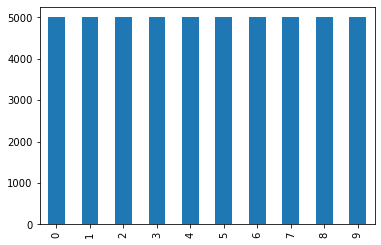

In [6]:
# === Your code here ===
import pandas as pd
ys_train_df = pd.DataFrame(ys_train)
ys_train_df.columns = ['label']
ys_train_df['label'].value_counts().plot(kind='bar')
print("In each category, there are 5000 images for train, but we don't know the test set.")
ys_train_df['label'].value_counts()
# ======================

### Section 1.3. Visualize one sample for each category. (5 points)

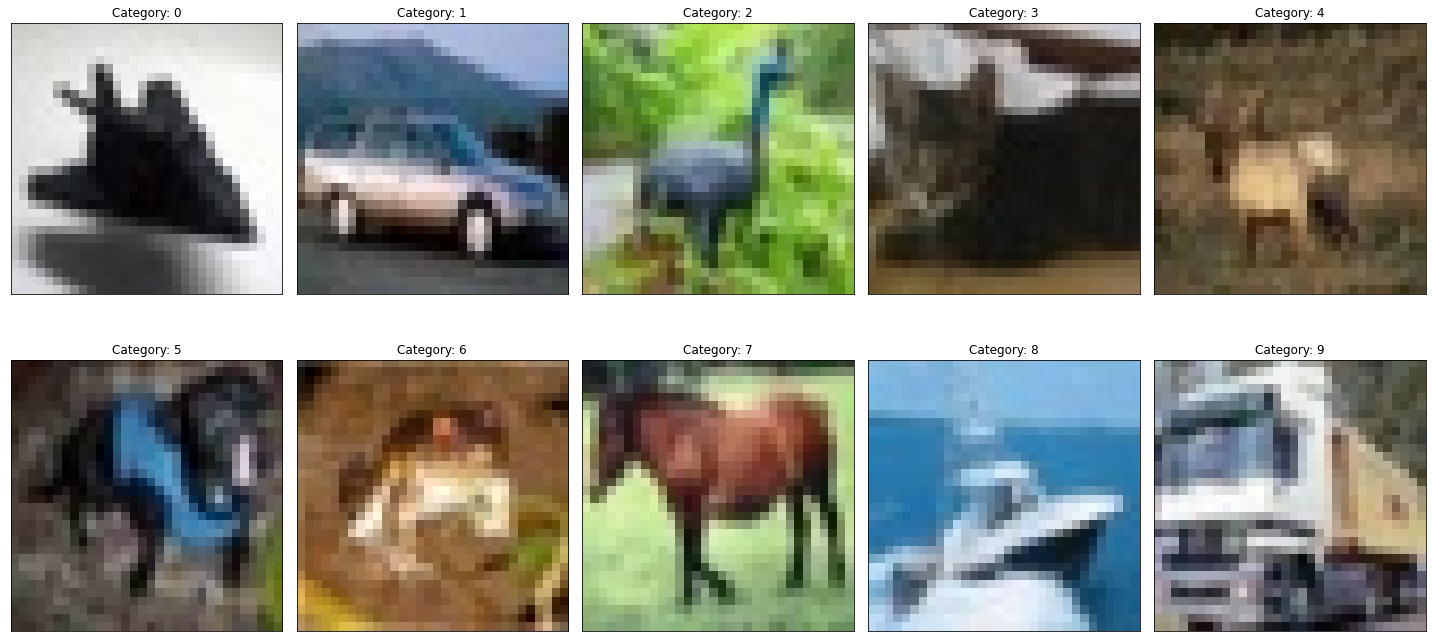

In [7]:
# === Your code here ===
import matplotlib.pyplot as plt

def plot10Image(xs_train=xs_train, ys_train=ys_train):
    fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(20, 10))
    ax = ax.flatten()
    for i in range(10):
        img = xs_train[ys_train == i][0].reshape(32, 32, 3)
        ax[i].imshow(img)
        ax[i].set_title("Category: {}".format(i))
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()
plot10Image()
# ======================

## Section 2.  Controlled experiments. (30 Points)

You are required to perform 3 controlled experiments. There are many aspects that you could explore in the controlled experiments, for example:

- Comparisons for different classifiers. 
- Tuning a hyper-parameter for a specific classifier.
- Different pre-processing methods, like normalization, extracting the edge features, grayscale, etc.   
- Ensembling, boosting, or voting methods.
- ...

You are required to explore at least 3 aspects. For each experiment, you should add a subsection in a text cell, and briefly explain your experimental results. To verify your results, you should split the validation set by yourself to carry out experiments to find out the best settings.

### Section 2.0. Divide Data

In [6]:
#backup xs_train and ys_train
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

xs_train_bk = xs_train.copy()
ys_train_bk = ys_train.copy()
xs_test_bk = xs_test.copy()

In [7]:
copy1 = xs_train_bk.copy()
copy2 = ys_train_bk.copy()
copy3 = xs_test_bk.copy()

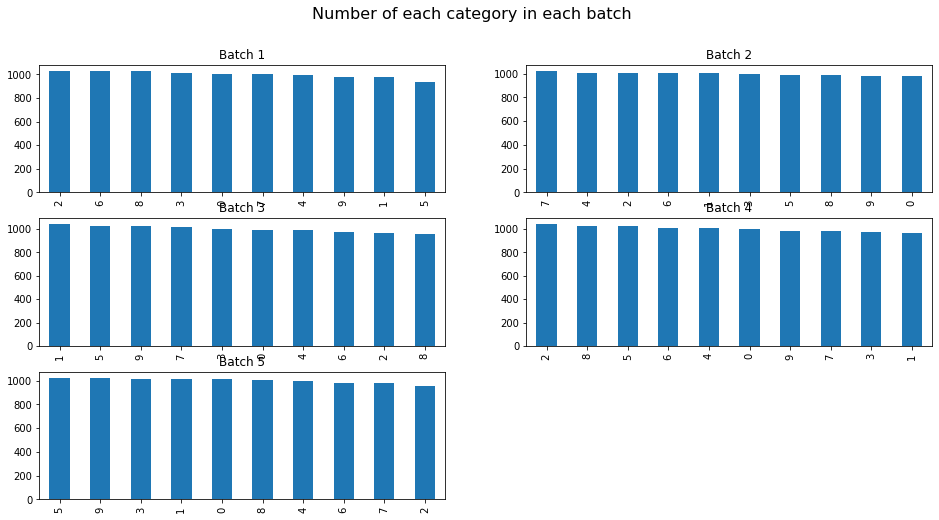

In [8]:
#divide xs_train and ys_train into 5 batches
xs_train = xs_train_bk.copy()
ys_train = ys_train_bk.copy()
xs_test = xs_test_bk.copy()

xs_train =  xs_train.reshape(50000, 3072)
ys_train = ys_train.ravel()
xs_test = xs_test.reshape(10000, 3072)

xs_train_1 = xs_train[0:10000]
ys_train_1 = ys_train[0:10000]
xs_train_2 = xs_train[10000:20000]
ys_train_2 = ys_train[10000:20000]
xs_train_3 = xs_train[20000:30000]
ys_train_3 = ys_train[20000:30000]
xs_train_4 = xs_train[30000:40000]
ys_train_4 = ys_train[30000:40000]
xs_train_5 = xs_train[40000:50000]
ys_train_5 = ys_train[40000:50000]

#calculate the number of each category in each batch
# create sub plots with 3 rows and 2 columns
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 8))
# set the title of the figure
fig.suptitle('Number of each category in each batch', fontsize=16)
# set the title of each sub plot
axes[0, 0].set_title('Batch 1')
axes[0, 1].set_title('Batch 2')
axes[1, 0].set_title('Batch 3')
axes[1, 1].set_title('Batch 4')
axes[2, 0].set_title('Batch 5')
# plot the number of each category in each batch
ys_train_1_df = pd.DataFrame(ys_train_1)
ys_train_1_df.columns = ['label']
ys_train_1_df['label'].value_counts().plot(kind='bar', ax=axes[0, 0])
ys_train_2_df = pd.DataFrame(ys_train_2)
ys_train_2_df.columns = ['label']
ys_train_2_df['label'].value_counts().plot(kind='bar', ax=axes[0, 1])
ys_train_3_df = pd.DataFrame(ys_train_3)
ys_train_3_df.columns = ['label']
ys_train_3_df['label'].value_counts().plot(kind='bar', ax=axes[1, 0])
ys_train_4_df = pd.DataFrame(ys_train_4)
ys_train_4_df.columns = ['label']
ys_train_4_df['label'].value_counts().plot(kind='bar', ax=axes[1, 1])
ys_train_5_df = pd.DataFrame(ys_train_5)
ys_train_5_df.columns = ['label']
ys_train_5_df['label'].value_counts().plot(kind='bar', ax=axes[2, 0])
# remove the x axis label of the last row
axes[2, 1].axis('off')
# remove the y axis label of the last column
axes[2, 1].axis('off')


xs_train_batch = [xs_train_1, xs_train_2, xs_train_3, xs_train_4, xs_train_5]
ys_train_batch = [ys_train_1, ys_train_2, ys_train_3, ys_train_4, ys_train_5]


### Section 2.1. Controlled experiment I. (10 points)

Comparison for different classifiers

#### Section 2.1.1 LogisticRegression

In [ ]:
# === Your code here ===
from sklearn.linear_model import LogisticRegression

batch = random.randint(0, 4)
x_train, x_val, y_train, y_val = train_test_split(xs_train_batch[batch], ys_train_batch[batch], test_size=0.2, random_state=0)
clf_log = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=1000, n_jobs=5).fit(x_train, y_train)
y_pred = clf_log.predict(x_val)
print("Accuracy of batch {} is {}".format(batch+1, accuracy_score(y_val, y_pred)))
# ======================

Accuracy of batch 3 is 0.3095


/Users/yimingzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Section 2.1.2 SVM

In [ ]:
#import svm
from sklearn import svm

# === Your code here ===
batch = random.randint(0, 4)
x_train, x_val, y_train, y_val = train_test_split(xs_train_batch[batch], ys_train_batch[batch], test_size=0.2, random_state=0)
clf_svm = svm.SVC(gamma='scale', decision_function_shape='ovr')
clf_svm.fit(x_train, y_train)
y_pred = clf_svm.predict(x_val)
print("Accuracy of batch {} is {}".format(batch+1, accuracy_score(y_val, y_pred)))

Accuracy of batch 3 is 0.4745


#### Section 2.1.3 MLP

In [ ]:
# import MLP
from sklearn.neural_network import MLPClassifier

# === Your code here ===
batch = random.randint(0, 4)
x_train, x_val, y_train, y_val = train_test_split(xs_train_batch[batch], ys_train_batch[batch], test_size=0.2, random_state=0)
clf_mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100, 100), random_state=0)
clf_mlp.fit(x_train, y_train)
y_pred = clf_mlp.predict(x_val)
print("Accuracy of batch {} is {}".format(batch+1, accuracy_score(y_val, y_pred)))

Accuracy of batch 4 is 0.2835


/Users/yimingzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
# import MLP
from sklearn.neural_network import MLPClassifier

# === Your code here ===
batch = random.randint(0, 4)
x_train, x_val, y_train, y_val = train_test_split(xs_train_batch[batch], ys_train_batch[batch], test_size=0.2, random_state=0)
clf_mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100, 100), random_state=0)
clf_mlp.fit(x_train.astype(np.float32) , y_train)
y_pred = clf_mlp.predict(x_val.astype(np.float32))
print("Accuracy of batch {} is {}".format(batch+1, accuracy_score(y_val, y_pred)))

Accuracy of batch 3 is 0.294


### Section 2.2. Controlled experiment II. (10 points) 

Pre-processing Data

We notice that even using scaler, logistic regression is so slow and not good.

We will not use logistic regression

In [ ]:
#import make_pipeline
from sklearn.pipeline import make_pipeline
#import StandardScaler, MinMaxScaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#import PCA
from sklearn.decomposition import PCA

#### Section 2.2.1. Normalization

Logistics Up
SVM Not changed
MLP Up

In [ ]:
pipe_clf_log = make_pipeline(MinMaxScaler(), clf_log)
pipe_clf_svm = make_pipeline(MinMaxScaler(), clf_svm)
pipe_clf_mlp = make_pipeline(MinMaxScaler(), clf_mlp)

batch = random.randint(0, 4)
x_train, x_val, y_train, y_val = train_test_split(xs_train_batch[batch], ys_train_batch[batch], test_size=0.2, random_state=0)
pipe_clf_log.fit(x_train, y_train)
y_pred = pipe_clf_log.predict(x_val)
print("Accuracy of batch {} is {}".format(batch+1, accuracy_score(y_val, y_pred)))

batch = random.randint(0, 4)
x_train, x_val, y_train, y_val = train_test_split(xs_train_batch[batch], ys_train_batch[batch], test_size=0.2, random_state=0)
pipe_clf_svm.fit(x_train, y_train)
y_pred = pipe_clf_svm.predict(x_val)
print("Accuracy of batch {} is {}".format(batch+1, accuracy_score(y_val, y_pred)))

batch = random.randint(0, 4)
x_train, x_val, y_train, y_val = train_test_split(xs_train_batch[batch], ys_train_batch[batch], test_size=0.2, random_state=0)
pipe_clf_mlp.fit(x_train, y_train)
y_pred = pipe_clf_mlp.predict(x_val)
print("Accuracy of batch {} is {}".format(batch+1, accuracy_score(y_val, y_pred)))


/Users/yimingzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy of batch 4 is 0.334
Accuracy of batch 3 is 0.4745
Accuracy of batch 5 is 0.413


/Users/yimingzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Check the difference using np.float32

In [ ]:
pipe_clf_log = make_pipeline(MinMaxScaler(), clf_log)
pipe_clf_svm = make_pipeline(MinMaxScaler(), clf_svm)
pipe_clf_mlp = make_pipeline(MinMaxScaler(), clf_mlp)

batch = random.randint(0, 4)
x_train, x_val, y_train, y_val = train_test_split(xs_train_batch[batch], ys_train_batch[batch], test_size=0.2, random_state=0)
x_train = x_train.astype(np.float32)
x_val = x_val.astype(np.float32)
pipe_clf_log.fit(x_train, y_train)
y_pred = pipe_clf_log.predict(x_val)
print("Accuracy of batch {} is {}".format(batch+1, accuracy_score(y_val, y_pred)))

batch = random.randint(0, 4)
x_train, x_val, y_train, y_val = train_test_split(xs_train_batch[batch], ys_train_batch[batch], test_size=0.2, random_state=0)
pipe_clf_svm.fit(x_train, y_train)
y_pred = pipe_clf_svm.predict(x_val)
print("Accuracy of batch {} is {}".format(batch+1, accuracy_score(y_val, y_pred)))

batch = random.randint(0, 4)
x_train, x_val, y_train, y_val = train_test_split(xs_train_batch[batch], ys_train_batch[batch], test_size=0.2, random_state=0)
pipe_clf_mlp.fit(x_train, y_train)
y_pred = pipe_clf_mlp.predict(x_val)
print("Accuracy of batch {} is {}".format(batch+1, accuracy_score(y_val, y_pred)))


/Users/yimingzhao/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy of batch 1 is 0.315
Accuracy of batch 1 is 0.118
Accuracy of batch 2 is 0.416


#### 2.2.2. Standardization

In [ ]:
pipe_clf_log = make_pipeline(StandardScaler(), clf_log)
pipe_clf_svm = make_pipeline(StandardScaler(), clf_svm)
pipe_clf_mlp = make_pipeline(StandardScaler(), clf_mlp)

batch = random.randint(0, 4)
x_train, x_val, y_train, y_val = train_test_split(xs_train_batch[batch], ys_train_batch[batch], test_size=0.2, random_state=0)
pipe_clf_log.fit(x_train, y_train)
y_pred = pipe_clf_log.predict(x_val)
print("Accuracy of batch {} is {}".format(batch+1, accuracy_score(y_val, y_pred)))

batch = random.randint(0, 4)
x_train, x_val, y_train, y_val = train_test_split(xs_train_batch[batch], ys_train_batch[batch], test_size=0.2, random_state=0)
pipe_clf_svm.fit(x_train, y_train)
y_pred = pipe_clf_svm.predict(x_val)
print("Accuracy of batch {} is {}".format(batch+1, accuracy_score(y_val, y_pred)))

batch = random.randint(0, 4)
x_train, x_val, y_train, y_val = train_test_split(xs_train_batch[batch], ys_train_batch[batch], test_size=0.2, random_state=0)
pipe_clf_mlp.fit(x_train, y_train)
y_pred = pipe_clf_mlp.predict(x_val)
print("Accuracy of batch {} is {}".format(batch+1, accuracy_score(y_val, y_pred)))


Accuracy of batch 2 is 0.2855
Accuracy of batch 5 is 0.462
Accuracy of batch 2 is 0.403


#### 2.2.3. Add PCA

In [ ]:
pipe_clf_svm = make_pipeline(MinMaxScaler() ,PCA(n_components=0.95), clf_svm)
pipe_clf_mlp = make_pipeline(MinMaxScaler() ,PCA(n_components=0.95), clf_mlp)

batch = random.randint(0, 4)
x_train, x_val, y_train, y_val = train_test_split(xs_train_batch[batch], ys_train_batch[batch], test_size=0.2, random_state=0)
pipe_clf_svm.fit(x_train, y_train)
y_pred = pipe_clf_svm.predict(x_val)
print("Accuracy of batch {} is {}".format(batch+1, accuracy_score(y_val, y_pred)))

batch = random.randint(0, 4)
x_train, x_val, y_train, y_val = train_test_split(xs_train_batch[batch], ys_train_batch[batch], test_size=0.2, random_state=0)
pipe_clf_mlp.fit(x_train, y_train)
y_pred = pipe_clf_mlp.predict(x_val)
print("Accuracy of batch {} is {}".format(batch+1, accuracy_score(y_val, y_pred)))

Accuracy of batch 3 is 0.473
Accuracy of batch 2 is 0.3985


In [ ]:
pipe_clf_svm = make_pipeline(StandardScaler() ,PCA(n_components=0.95), clf_svm)
pipe_clf_mlp = make_pipeline(StandardScaler() ,PCA(n_components=0.95), clf_mlp)

batch = random.randint(0, 4)
x_train, x_val, y_train, y_val = train_test_split(xs_train_batch[batch], ys_train_batch[batch], test_size=0.2, random_state=0)
pipe_clf_svm.fit(x_train, y_train)
y_pred = pipe_clf_svm.predict(x_val)
print("Accuracy of batch {} is {}".format(batch+1, accuracy_score(y_val, y_pred)))

batch = random.randint(0, 4)
x_train, x_val, y_train, y_val = train_test_split(xs_train_batch[batch], ys_train_batch[batch], test_size=0.2, random_state=0)
pipe_clf_mlp.fit(x_train, y_train)
y_pred = pipe_clf_mlp.predict(x_val)
print("Accuracy of batch {} is {}".format(batch+1, accuracy_score(y_val, y_pred)))

Accuracy of batch 1 is 0.4865
Accuracy of batch 5 is 0.3845


#### 2.2.4. Grey Scaler

In [ ]:
#gray scale
batch = random.randint(0, 4)
x_train, x_val, y_train, y_val = train_test_split(xs_train_batch[batch], ys_train_batch[batch], test_size=0.2, random_state=0)
x_used_train = []
x_used_val = []

for i in range(len(x_train)):
    xi = np.dot(x_train[i].reshape(32,32,3), [0.299, 0.587, 0.114])
    x_used_train.append(xi.reshape(1024))
for i in range(len(x_val)):
    xi = np.dot(x_val[i].reshape(32,32,3), [0.299, 0.587, 0.114])
    x_used_val.append(xi.reshape(1024))

pipe_clf_svm.fit(x_used_train, y_train)
y_pred = pipe_clf_svm.predict(x_used_val)
print("Accuracy of batch {} is {}".format(batch+1, accuracy_score(y_val, y_pred)))

Accuracy of batch 5 is 0.385


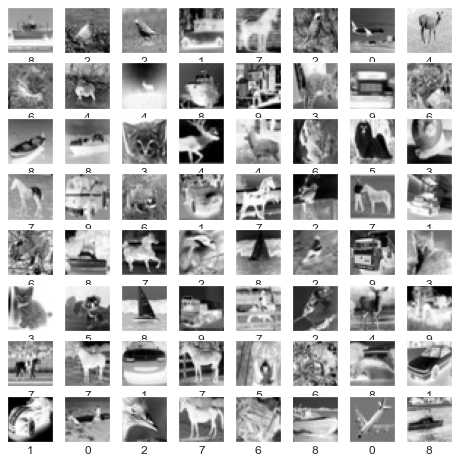

In [ ]:
#plot x_used_train
plt.figure(figsize=(8,8))
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_used_train[i].reshape(32,32), cmap=plt.cm.binary)
    plt.xlabel(y_train[i])

#### 2.2.5. t-SNE

In [ ]:
# import t-SNE
from sklearn.manifold import TSNE
# import train_test_split
from sklearn.model_selection import train_test_split
# create t-SNE model
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3)

batch = random.randint(0, 4)
x_train, x_val, y_train, y_val = train_test_split(xs_train_batch[batch], ys_train_batch[batch], test_size=0.2, random_state=0)

x_train_reduced_tsne = tsne.fit_transform(x_train)
x_val_reduced_tsne = tsne.fit_transform(x_val)

# fit and transform t-SNE
pipe_t_sne = make_pipeline(MinMaxScaler(), clf_svm)
pipe_t_sne.fit(x_train_reduced_tsne, y_train)
y_pred = pipe_t_sne.predict(x_val_reduced_tsne)
print("Accuracy of batch {} is {}".format(batch+1, accuracy_score(y_val, y_pred)))





Accuracy of batch 4 is 0.1015


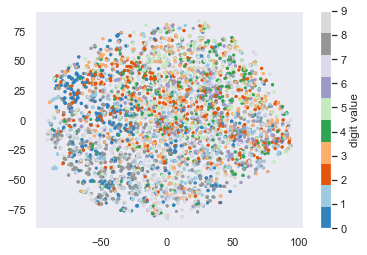

In [ ]:
def visualize2DCluster(xs_reduced, ys):
    plt.figure().patch.set_facecolor('white')
    plt.scatter(xs_reduced[:, 0], xs_reduced[:, 1], lw=0.1,
                c=ys, cmap=plt.cm.get_cmap('tab20c', 10), marker='.')
    plt.colorbar(ticks=range(10), label='digit value')
    plt.grid(False)
    plt.show()

visualize2DCluster(x_train_reduced_tsne, y_train)

### Section 2.3. Controlled experiment III. (10 points)

Ensemble Learning, boosting

In [ ]:
#import bagging classifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
#from sklearn import xgbboosting

from xgboost import XGBClassifier
#bagging classifier
bag_clf = BaggingClassifier(n_estimators=100, n_jobs=4, random_state=0, verbose=1)

#random forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, n_jobs=4, random_state=0, verbose=1)

#ada boost classifier
ada_clf = AdaBoostClassifier(n_estimators=100, random_state=0)

#gradient boost classifier
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=0, verbose=1, max_depth=2) # so slow we will not try it

#xgboost classifier
xgb_clf = XGBClassifier(n_estimators=100, n_jobs=4, random_state=0, verbose=1)

#hist gradient boosting classifier
histgb_clf = HistGradientBoostingClassifier(random_state=0, verbose=1)

#### 2.3.1. Random Forest

0.4275


In [ ]:
print("Random Forest Classifier")
batch = random.randint(0, 4)
x_train, x_val, y_train, y_val = train_test_split(xs_train_batch[batch], ys_train_batch[batch], test_size=0.2, random_state=0)
rf_clf.fit(x_train, y_train)
y_pred = rf_clf.predict(x_val)
print("Accuracy of batch {} is {}".format(batch+1, accuracy_score(y_val, y_pred)))

Random Forest Classifier


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.2s


Accuracy of batch 3 is 0.4275


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


#### 2.3.2. XGBoosting

0.4855

In [ ]:
print("XGBoost Classifier")
batch = random.randint(0, 4)
x_train, x_val, y_train, y_val = train_test_split(xs_train_batch[batch], ys_train_batch[batch], test_size=0.2, random_state=0)
xgb_clf.fit(x_train, y_train)
y_pred = xgb_clf.predict(x_val)
print("Accuracy of batch {} is {}".format(batch+1, accuracy_score(y_val, y_pred)))

XGBoost Classifier
[23:35:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

Accuracy of batch 1 is 0.4855


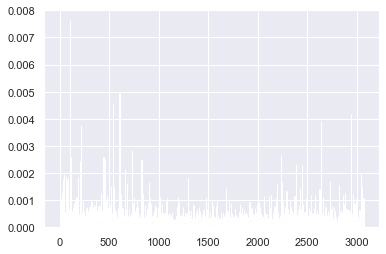

0.00032552084


In [ ]:
importanceList = xgb_clf.feature_importances_
# summarize feature importance
# plot feature importance
plt.bar([x for x in range(len(importanceList))], importanceList)
plt.show()
print(importanceList.mean())

In [ ]:
print("XGBoost Classifier")
batch = random.randint(0, 4)
x_train, x_val, y_train, y_val = train_test_split(xs_train_batch[batch], ys_train_batch[batch], test_size=0.2, random_state=0)

reduced_x_train = x_train[:, importanceList > importanceList.mean()]
reduced_x_val = x_val[:, importanceList > importanceList.mean()]

xgb_clf.fit(reduced_x_train, y_train)
y_pred = xgb_clf.predict(reduced_x_val)
print("Accuracy of batch {} is {}".format(batch+1, accuracy_score(y_val, y_pred)))

XGBoost Classifier
[23:51:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

Accuracy of batch 1 is 0.4765


In [ ]:
y_pred = xgb_clf.predict(reduced_x_val)
print("Accuracy of batch {} is {}".format(batch+1, accuracy_score(y_val, y_pred)))

Accuracy of batch 1 is 0.4765


In [ ]:
listReduce = importanceList[importanceList > importanceList.mean()]
trueList = importanceList > importanceList.mean()
print(listReduce.shape)

(1041,)


#### 2.3.3. Adaboosting

0.308

In [ ]:
print("Ada Boost Classifier")
batch = random.randint(0, 4)
x_train, x_val, y_train, y_val = train_test_split(xs_train_batch[batch], ys_train_batch[batch], test_size=0.2, random_state=0)
ada_clf.fit(x_train, y_train)
y_pred = ada_clf.predict(x_val)
print("Accuracy of batch {} is {}".format(batch+1, accuracy_score(y_val, y_pred)))

Ada Boost Classifier
Accuracy of batch 3 is 0.308


#### 2.3.4. Bagging 

0.4035

In [ ]:
print("Bagging Classifier")
batch = random.randint(0, 4)
x_train, x_val, y_train, y_val = train_test_split(xs_train_batch[batch], ys_train_batch[batch], test_size=0.2, random_state=0)
bag_clf.fit(x_train, y_train)
y_pred = bag_clf.predict(x_val)
print("Accuracy of batch {} is {}".format(batch+1, accuracy_score(y_val, y_pred)))

Bagging Classifier


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  6.7min remaining:  6.7min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  6.8min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.8s finished


Accuracy of batch 4 is 0.4035


#### 2.3.5. Gradient

So slow, not used

In [ ]:
print("Gradient Boost Classifier")
batch = random.randint(0, 4)
x_train, x_val, y_train, y_val = train_test_split(xs_train_batch[batch], ys_train_batch[batch], test_size=0.2, random_state=0)
gb_clf.fit(x_train, y_train)
y_pred = gb_clf.predict(x_val)
print("Accuracy of batch {} is {}".format(batch+1, accuracy_score(y_val, y_pred)))



#### 2.3.6. HistGradient

0.4675

In [ ]:
print("HistGradientBoostingClassifier")
batch = random.randint(0, 4)
x_train, x_val, y_train, y_val = train_test_split(xs_train_batch[batch], ys_train_batch[batch], test_size=0.2, random_state=0)
histgb_clf.fit(x_train, y_train)
y_pred = histgb_clf.predict(x_val)
print("Accuracy of batch {} is {}".format(batch+1, accuracy_score(y_val, y_pred)))


HistGradientBoostingClassifier
Binning 0.197 GB of training data: 4.725 s
Fitting gradient boosted rounds:
[1/100] 10 trees, 310 leaves (31 on avg), max depth = 17, in 2.331s
[2/100] 10 trees, 310 leaves (31 on avg), max depth = 13, in 2.406s
[3/100] 10 trees, 310 leaves (31 on avg), max depth = 18, in 2.348s
[4/100] 10 trees, 310 leaves (31 on avg), max depth = 17, in 2.224s
[5/100] 10 trees, 310 leaves (31 on avg), max depth = 13, in 2.072s
[6/100] 10 trees, 310 leaves (31 on avg), max depth = 15, in 2.148s
[7/100] 10 trees, 310 leaves (31 on avg), max depth = 15, in 2.154s
[8/100] 10 trees, 310 leaves (31 on avg), max depth = 17, in 2.789s
[9/100] 10 trees, 310 leaves (31 on avg), max depth = 13, in 2.486s
[10/100] 10 trees, 310 leaves (31 on avg), max depth = 16, in 2.497s
[11/100] 10 trees, 310 leaves (31 on avg), max depth = 19, in 2.829s
[12/100] 10 trees, 310 leaves (31 on avg), max depth = 15, in 2.381s
[13/100] 10 trees, 310 leaves (31 on avg), max depth = 17, in 3.365s
[14/1

### Section 2.4. Controlled experiment IV.

Tuning Parameter

for 

+ SVM

+ RF

+ HIST

+ XGB

#### 2.4.1. SVM Tuning Together with PCA

~ 0.47

fitting on 4 batches reaches around $\red{0.54}$ accuracy

##### 2.4.1.1. PCA

In [ ]:
pca = PCA(n_components=0.95)
pipe_PCA = make_pipeline(StandardScaler(), pca)
pipe_PCA.fit(xs_train)



Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.95))])

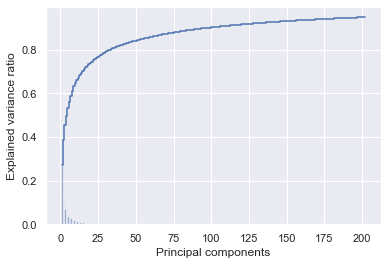

In [ ]:
plt.bar(range(1, 203), pipe_PCA['pca'].explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, 203), np.cumsum(pipe_PCA['pca'].explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.show()

In [ ]:
#import svm
from sklearn import svm

# === Your code here ===

clf_svm = svm.SVC(gamma='scale', decision_function_shape='ovr')
batch = random.randint(0, 4)
x_train, x_val, y_train, y_val = train_test_split(xs_train_batch[batch], ys_train_batch[batch], test_size=0.2, random_state=0)

pcaL = []
scoreL = []
model = []
for i in np.arange(0.8, 0.96, 0.05):
    

    pipe_lr_svm = make_pipeline(StandardScaler(), PCA(n_components=i), clf_svm)

    pipe_lr_svm.fit(x_train, y_train)
    y_pred = pipe_lr_svm.predict(x_val)
    print("PCA with {} components".format(i))
    print("Accuracy of batch {} is {}".format(batch+1, accuracy_score(y_val, y_pred)))
    pcaL.append(i)
    model.append(pipe_lr_svm)
    scoreL.append(accuracy_score(y_val, y_pred))

PCA with 0.8 components
Accuracy of batch 5 is 0.443
PCA with 0.8500000000000001 components
Accuracy of batch 5 is 0.445
PCA with 0.9000000000000001 components
Accuracy of batch 5 is 0.4575
PCA with 0.9500000000000002 components
Accuracy of batch 5 is 0.4585


In [ ]:
for i in range(4):
    print(model[i]['pca'].explained_variance_ratio_.shape)

(33,)
(54,)
(95,)
(196,)


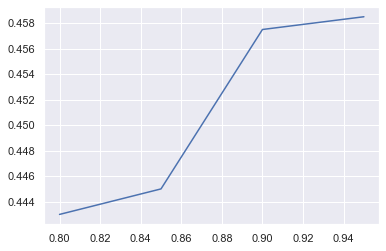

In [ ]:
plt.plot(pcaL, scoreL)

##### 2.4.1.2. SVM 

Gamma 0.0001 C 10.0

Since 0.95/0.9 PCA remove many not significantly important informations and keep accuracy, we will use 0.95/0.9

In [ ]:
#import svm
from sklearn import svm

# === Your code here ===


batch = random.randint(0, 4)
x_train, x_val, y_train, y_val = train_test_split(xs_train_batch[batch], ys_train_batch[batch], test_size=0.2, random_state=0)

kernel = ['linear', 'poly', 'rbf', 'sigmoid']
scoreL = []
model = []
for i in kernel:

    clf_svm = svm.SVC(gamma='scale', decision_function_shape='ovr', kernel=i) 
    pipe_lr_svm = make_pipeline(StandardScaler(), PCA(n_components=0.95), clf_svm)

    pipe_lr_svm.fit(x_train, y_train)
    y_pred = pipe_lr_svm.predict(x_val)
    print("kernel is {}".format(i))
    print("Accuracy of batch {} is {}".format(batch+1, accuracy_score(y_val, y_pred)))

    model.append(pipe_lr_svm)
    scoreL.append(accuracy_score(y_val, y_pred))

kernel is linear
Accuracy of batch 5 is 0.3635
kernel is poly
Accuracy of batch 5 is 0.369
kernel is rbf
Accuracy of batch 5 is 0.4585
kernel is sigmoid
Accuracy of batch 5 is 0.2325


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

batch = random.randint(0, 4)
x_train, x_val, y_train, y_val = train_test_split(xs_train_batch[batch], ys_train_batch[batch], test_size=0.2, random_state=0)

pipe_svc = make_pipeline(StandardScaler(), PCA(n_components=0.95) , SVC(random_state=0, decision_function_shape='ovr'))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
for gamma in param_range:
    for C in param_range:
        pipe_svc.set_params(svc__gamma=gamma, svc__C=C)
        pipe_svc.fit(x_train, y_train)
        if pipe_svc.score(x_val, y_val) > 0.4:
            print('gamma: %.4f C: %.4f' % (gamma, C))
            print("Using batch {}".format(batch+1))
            print('Test Accuracy: %.5f' % pipe_svc.score(x_val, y_val))
            print("=====================================")

gamma: 0.0001 C: 1.0000
Using batch 3
Test Accuracy: 0.43800
gamma: 0.0001 C: 10.0000
Using batch 3
Test Accuracy: 0.46600
gamma: 0.0001 C: 100.0000
Using batch 3
Test Accuracy: 0.43950
gamma: 0.0001 C: 1000.0000
Using batch 3
Test Accuracy: 0.43900
gamma: 0.0010 C: 1.0000
Using batch 3
Test Accuracy: 0.46050
gamma: 0.0010 C: 10.0000
Using batch 3
Test Accuracy: 0.46350
gamma: 0.0010 C: 100.0000
Using batch 3
Test Accuracy: 0.46350
gamma: 0.0010 C: 1000.0000
Using batch 3
Test Accuracy: 0.46350


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(), PCA(n_components=0.9) , SVC(random_state=0, decision_function_shape='ovr', gamma=0.0001, C=10.0))

for batch in range(5):
    #use one batch to train other to test
    x_train = np.concatenate((xs_train_batch[batch-1], xs_train_batch[batch-2], xs_train_batch[batch-3], xs_train_batch[batch-4]))
    y_train = np.concatenate((ys_train_batch[batch-1], ys_train_batch[batch-2], ys_train_batch[batch-3], ys_train_batch[batch-4]))
    x_val = xs_train_batch[batch]
    y_val = ys_train_batch[batch]
    pipe_svc.fit(x_val, y_val)
    print("Using batch {}".format(batch+1))
    print('Test Accuracy: %.5f' % pipe_svc.score(x_train, y_train))
    print("=====================================")

Using batch 1
Test Accuracy: 0.47075
Using batch 2
Test Accuracy: 0.47082
Using batch 3
Test Accuracy: 0.46532
Using batch 4
Test Accuracy: 0.46840
Using batch 5
Test Accuracy: 0.46787


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(), PCA(n_components=0.95) , SVC(random_state=0, decision_function_shape='ovr', gamma=0.0001, C=10.0))

batch = 3
x_train = np.concatenate((xs_train_batch[batch-1], xs_train_batch[batch-2], xs_train_batch[batch-3], xs_train_batch[batch-4]))
y_train = np.concatenate((ys_train_batch[batch-1], ys_train_batch[batch-2], ys_train_batch[batch-3], ys_train_batch[batch-4]))
x_val = xs_train_batch[batch]
y_val = ys_train_batch[batch]
pipe_svc.fit(x_train, y_train)
print("Using batch {}".format(batch+1))
print('Test Accuracy: %.5f' % pipe_svc.score(x_val, y_val))
print("=====================================")

Using batch 4
Test Accuracy: 0.53710


We will use np.float32 to train to see the difference between uint8

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(), PCA(n_components=0.95) , SVC(random_state=0, decision_function_shape='ovr', gamma=0.0001, C=10.0))

batch = 3
x_train = np.concatenate((xs_train_batch[batch-1], xs_train_batch[batch-2], xs_train_batch[batch-3], xs_train_batch[batch-4])).astype(np.float32)
y_train = np.concatenate((ys_train_batch[batch-1], ys_train_batch[batch-2], ys_train_batch[batch-3], ys_train_batch[batch-4])).astype(np.float32)
x_val = xs_train_batch[batch].astype(np.float32)
y_val = ys_train_batch[batch].astype(np.float32)
pipe_svc.fit(x_train, y_train)
print("Using batch {}".format(batch+1))
print('Test Accuracy: %.5f' % pipe_svc.score(x_val, y_val))
print("=====================================")

Using batch 4
Test Accuracy: 0.53720


#### 2.4.2. Random Forest

< 0.45

Using batch 2
n estimator is 100
Test Accuracy: 0.40650
Using batch 2
n estimator is 200
Test Accuracy: 0.42400
Using batch 2
n estimator is 300
Test Accuracy: 0.43850
Using batch 2
n estimator is 400
Test Accuracy: 0.43900
Using batch 2
n estimator is 500
Test Accuracy: 0.44250
Using batch 2
n estimator is 600
Test Accuracy: 0.43950
Using batch 2
n estimator is 700
Test Accuracy: 0.43500
Using batch 2
n estimator is 800
Test Accuracy: 0.43600
Using batch 2
n estimator is 900
Test Accuracy: 0.43800
Using batch 2
n estimator is 1000
Test Accuracy: 0.43650


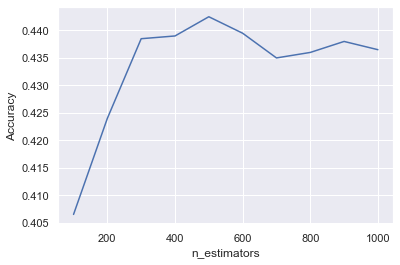

In [ ]:
#import random forest
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=0)

batch = random.randint(0, 4)
x_train, x_val, y_train, y_val = train_test_split(xs_train_batch[batch], ys_train_batch[batch], test_size=0.2, random_state=0)

scoreL = []
for n in range(100, 1001, 100):
    rf_clf.set_params(n_estimators=n)
    rf_clf.fit(x_train, y_train)
    print("Using batch {}".format(batch+1))
    print("n estimator is {}".format(n))
    score = rf_clf.score(x_val, y_val)
    print('Test Accuracy: %.5f' % score)
    print("=====================================")
    scoreL.append(score)

plt.plot(range(100, 1001, 100), scoreL)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.show()



We will try to use np.int instead of uint8 to train to see the difference

Using batch 2
depth is 10
Test Accuracy: 0.41450
Using batch 2
depth is 20
Test Accuracy: 0.42900
Using batch 2
depth is 30
Test Accuracy: 0.43900
Using batch 2
depth is 40
Test Accuracy: 0.44250
Using batch 2
depth is 50
Test Accuracy: 0.44250
Using batch 2
depth is 60
Test Accuracy: 0.44250


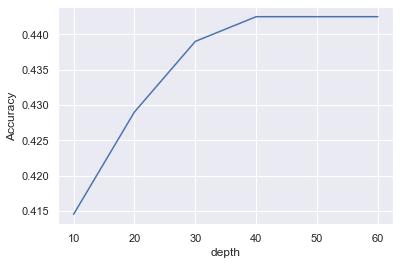

In [ ]:
#import random forest
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=0)

batch = random.randint(0, 4)
x_train, x_val, y_train, y_val = train_test_split(xs_train_batch[batch], ys_train_batch[batch], test_size=0.2, random_state=0)

scoreL = []
for n in range(10,61,10):
    rf_clf.set_params(max_depth=n)
    rf_clf.fit(x_train.astype(np.int32), y_train)
    print("Using batch {}".format(batch+1))
    print("depth is {}".format(n))
    score = rf_clf.score(x_val.astype(np.int32), y_val)
    print('Test Accuracy: %.5f' % score)
    print("=====================================")
    scoreL.append(score)

plt.plot(range(10,61,10), scoreL)
plt.xlabel('depth')
plt.ylabel('Accuracy')
plt.show()



#### 2.4.3. Histogradient

0.49

Fitting on 4 batches reaches around $\red{0.56}$ accuracy

the model is not fast. only tuning a few parameter

we choose 300 max_iter, since 1000 is so slow but improves a little

learning rate 0.1, max_leaf_node = 32

##### pre tuning

Using batch 5
max iter is 100
Test Accuracy: 0.46350
Time used: 287.5138952732086
Using batch 5
max iter is 500
Test Accuracy: 0.48100
Time used: 902.9178471565247
Using batch 5
max iter is 1000
Test Accuracy: 0.48300
Time used: 1061.878870010376


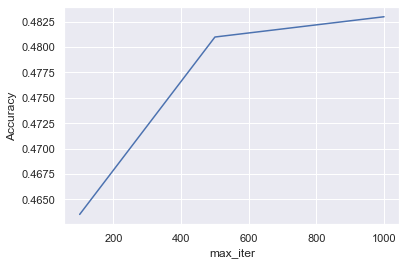

In [ ]:
#import histogram gradient boosting
from sklearn.experimental import enable_hist_gradient_boosting
# import warning
from sklearn.exceptions import ConvergenceWarning
#ignore warning
import warnings
import time
warnings.filterwarnings("ignore", category=ConvergenceWarning)

histgb_clf = HistGradientBoostingClassifier(random_state=0)

batch = random.randint(0, 4)
x_train, x_val, y_train, y_val = train_test_split(xs_train_batch[batch], ys_train_batch[batch], test_size=0.2, random_state=0)

scoreL = []
histL = []
for n in [100, 500, 1000]:
    start = time.time()
    histgb_clf.set_params(max_iter=n)
    histgb_clf.fit(x_train, y_train)
    print("Using batch {}".format(batch+1))
    print("max iter is {}".format(n))
    score = histgb_clf.score(x_val, y_val)
    print('Test Accuracy: %.5f' % score)
    print("=====================================")
    scoreL.append(score)
    histL.append(histgb_clf)
    # print time
    print("Time used: {}".format(time.time() - start))

plt.plot([100, 500, 1000], scoreL)
plt.xlabel('max_iter')
plt.ylabel('Accuracy')
plt.show()


    

In [ ]:
batch = 3
x_train = np.concatenate((xs_train_batch[batch-1], xs_train_batch[batch-2], xs_train_batch[batch-3], xs_train_batch[batch-4]))
y_train = np.concatenate((ys_train_batch[batch-1], ys_train_batch[batch-2], ys_train_batch[batch-3], ys_train_batch[batch-4]))
print("Feed on batch {}".format(2))
print("Using batch to score {}".format(batch+1))
print('Test Accuracy: %.5f' % histgb_clf.score(x_train, y_train))
print("=====================================")
print("*"*50)

Feed on batch 2
Using batch to score 4
Test Accuracy: 0.49700
**************************************************


In [ ]:
batch = 3
x_train = np.concatenate((xs_train_batch[batch-1], xs_train_batch[batch-2], xs_train_batch[batch-3], xs_train_batch[batch-4]))
y_train = np.concatenate((ys_train_batch[batch-1], ys_train_batch[batch-2], ys_train_batch[batch-3], ys_train_batch[batch-4]))
print("Feed on batch {}".format(2)) #2 is a tempo
print("Using 4 batches to train and 1 batch to score")
print("Using batch to score {}".format(batch+1))
histgb_clf.fit(x_train, y_train)
print('Test Accuracy: %.5f' % histgb_clf.score(xs_train_batch[batch], ys_train_batch[batch]))
print("=====================================")
print("*"*50)

#result of using 600 as max iter

Feed on batch 2
Using 4 batches to train and 1 batch to score
Using batch to score 4
Test Accuracy: 0.54890
**************************************************


##### Further tuning on CS GPU farm. (I run other model at the same time on my macbook to save time)

Because this model is slow, I tuned on CS gpu farm at the same time, below it the finding and output.

In [ ]:
#import histogram gradient boosting
from sklearn.experimental import enable_hist_gradient_boosting
# import warning
from sklearn.exceptions import ConvergenceWarning
#ignore warning
import warnings
import time
from sklearn.metrics import accuracy_score
from sklearn.ensemble import HistGradientBoostingClassifier

warnings.filterwarnings("ignore", category=ConvergenceWarning)

histgb_clf = HistGradientBoostingClassifier(random_state=0)

batch = random.randint(0, 4)
x_train = np.concatenate((xs_train_batch[batch-1], xs_train_batch[batch-2], xs_train_batch[batch-3], xs_train_batch[batch-4]))
y_train = np.concatenate((ys_train_batch[batch-1], ys_train_batch[batch-2], ys_train_batch[batch-3], ys_train_batch[batch-4]))

scoreL = []
histL = []
modelL = []
for n in range(100, 401,100):
    start = time.time()
    histgb_clf.set_params(max_iter=n)
    print("Max iter is {}".format(n))
    histgb_clf.fit(x_train, y_train)
    score = histgb_clf.score(xs_train_batch[batch], ys_train_batch[batch])
    print('Test Accuracy: %.5f' % score)
    scoreL.append(score)
    histL.append(histgb_clf)
    modelL.append(histgb_clf)
    print("Time used: {}".format(time.time() - start))
    print("=====================================")

print("The output of tuning: (Becasue there is another file running on CS gpu farm")
print("""
Max iter is 100
Test Accuracy: 0.52960
Time used: 423.80290126800537
=====================================
Max iter is 200
Test Accuracy: 0.55000
Time used: 803.8096883296967
=====================================
Max iter is 300
Test Accuracy: 0.55860
Time used: 1120.8148920536041
=====================================
Max iter is 400
Test Accuracy: 0.55860
Time used: 1149.4365949630737
=====================================""")
    

In [ ]:
#import histogram gradient boosting
from sklearn.experimental import enable_hist_gradient_boosting
# import warning
from sklearn.exceptions import ConvergenceWarning
#ignore warning
import warnings
import time
from sklearn.metrics import accuracy_score
from sklearn.ensemble import HistGradientBoostingClassifier

'''
sklearn.ensemble.HistGradientBoostingClassifier(loss='log_loss', *, learning_rate=0.1, max_iter=100, 
max_leaf_nodes=31, max_depth=None, min_samples_leaf=20, l2_regularization=0.0, max_bins=255, categorical_features=None, 
monotonic_cst=None, warm_start=False, early_stopping='auto', scoring='loss', validation_fraction=0.1, n_iter_no_change=10, tol=1e-07, verbose=0, random_state=None)'''

warnings.filterwarnings("ignore", category=ConvergenceWarning)

histgb_clf = HistGradientBoostingClassifier(random_state=0, max_iter=300)

batch = random.randint(0, 4)
x_train = np.concatenate((xs_train_batch[batch-1], xs_train_batch[batch-2], xs_train_batch[batch-3], xs_train_batch[batch-4]))
y_train = np.concatenate((ys_train_batch[batch-1], ys_train_batch[batch-2], ys_train_batch[batch-3], ys_train_batch[batch-4]))

scoreL = []
histL = []
modelL = []
for max_leaf_nodes in [3, 10, 30]:
    for learning_rate in [0.01, 0.1, 1.0, 10.0]:
        start = time.time()
        histgb_clf.set_params(max_leaf_nodes=max_leaf_nodes, learning_rate=learning_rate)
        print("max_leaf_nodes is {}".format(max_leaf_nodes))
        print("learning_rate is {}".format(learning_rate))
        histgb_clf.fit(x_train, y_train)
        score = histgb_clf.score(xs_train_batch[batch], ys_train_batch[batch])
        print('Test Accuracy: %.5f' % score)
        scoreL.append(score)
        histL.append(histgb_clf)
        modelL.append(histgb_clf)
        print("Time used: {}".format(time.time() - start))
        print("=====================================")

print("The output of tuning: (Becasue there is another file running on CS gpu farm")
print("""max_leaf_nodes is 3
learning_rate is 0.01
Test Accuracy: 0.37280
Time used: 309.8559515476227
=====================================
max_leaf_nodes is 3
learning_rate is 0.1
Test Accuracy: 0.47120
Time used: 279.22262954711914
=====================================
max_leaf_nodes is 3
learning_rate is 1.0
Test Accuracy: 0.37540
Time used: 48.33300280570984
=====================================
max_leaf_nodes is 3
learning_rate is 10.0
Test Accuracy: 0.05060
Time used: 30.229432344436646
=====================================
max_leaf_nodes is 10
learning_rate is 0.01
Test Accuracy: 0.44720
Time used: 625.4553864002228
=====================================
max_leaf_nodes is 10
learning_rate is 0.1
Test Accuracy: 0.53290
Time used: 527.0453741550446
=====================================
max_leaf_nodes is 10
learning_rate is 1.0
Test Accuracy: 0.35120
Time used: 45.06897234916687
=====================================
max_leaf_nodes is 10
learning_rate is 10.0
Test Accuracy: 0.14660
Time used: 33.06566381454468
=====================================
max_leaf_nodes is 30
learning_rate is 0.01
Test Accuracy: 0.49520
Time used: 1284.7996051311493
=====================================
max_leaf_nodes is 30
learning_rate is 0.1
Test Accuracy: 0.56300
Time used: 1155.6011807918549
=====================================
max_leaf_nodes is 30
learning_rate is 1.0
Test Accuracy: 0.33910
Time used: 54.28485083580017
=====================================
max_leaf_nodes is 30
learning_rate is 10.0
Test Accuracy: 0.15550
Time used: 34.749528646469116
=====================================
"""
)

In [ ]:
#import histogram gradient boosting
from sklearn.experimental import enable_hist_gradient_boosting
# import warning
from sklearn.exceptions import ConvergenceWarning
#ignore warning
import warnings
import time
from sklearn.metrics import accuracy_score
from sklearn.ensemble import HistGradientBoostingClassifier

warnings.filterwarnings("ignore", category=ConvergenceWarning)

histgb_clf = HistGradientBoostingClassifier(random_state=0, max_iter=300, learning_rate=0.1)


batch = random.randint(0, 4)
x_train = np.concatenate((xs_train_batch[batch-1], xs_train_batch[batch-2], xs_train_batch[batch-3], xs_train_batch[batch-4]))
y_train = np.concatenate((ys_train_batch[batch-1], ys_train_batch[batch-2], ys_train_batch[batch-3], ys_train_batch[batch-4]))

scoreL = []
histL = []
modelL = []
for n in range(26,35,2):
    start = time.time()
    histgb_clf.set_params(max_leaf_nodes=n)
    print("Max leaf nodes is {}".format(n))
    histgb_clf.fit(x_train, y_train)
    score = histgb_clf.score(xs_train_batch[batch], ys_train_batch[batch])
    print('Test Accuracy: %.5f' % score)
    scoreL.append(score)
    histL.append(histgb_clf)
    modelL.append(histgb_clf)
    print("Time used: {}".format(time.time() - start))
    print("=====================================")

print("The output of tuning: (Becasue there is another file running on CS gpu farm")
print("""Max leaf nodes is 26
Test Accuracy: 0.55890
Time used: 1089.025028705597
=====================================
Max leaf nodes is 28
Test Accuracy: 0.56610
Time used: 1137.4399983882904
=====================================
Max leaf nodes is 30
Test Accuracy: 0.56300
Time used: 1197.6283972263336
=====================================
Max leaf nodes is 32
Test Accuracy: 0.56690
Time used: 1211.519159078598
=====================================
Max leaf nodes is 34
Test Accuracy: 0.56280
Time used: 1326.8837177753448
=====================================""")


#### 2.4.4. XGBoosting

0.4855

Fitting on 4 batches reaches around $\red{0.58}$ accuracy

the model is not fast. we use CS GPU to speed up. (xgboost supports GPU)


xgb_clf = xgb.XGBClassifier(n_estimators=800, n_jobs=-1, random_state=0, tree_method='gpu_hist', max_depth=5, min_child_weight=4)

Other parameter remains default

Using batch 5
Test Accuracy: 0.46050
Using batch 5
Test Accuracy: 0.46650
Using batch 5
Test Accuracy: 0.47200
Using batch 5
Test Accuracy: 0.47300


Text(0, 0.5, 'Accuracy')

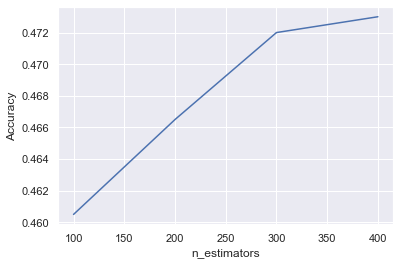

In [ ]:
#import xgb
from xgboost import XGBClassifier


#xgboost classifier
xgb_clf = XGBClassifier(n_estimators=100, n_jobs=4, random_state=0)

batch = random.randint(0, 4)
x_train, x_val, y_train, y_val = train_test_split(xs_train_batch[batch], ys_train_batch[batch], test_size=0.2, random_state=0)

scoreL = []
xgbL = []
for n in range(100, 401, 100):
    xgb_clf.set_params(n_estimators=n)
    xgb_clf.fit(x_train, y_train)
    print("Using batch {}".format(batch+1))
    score = xgb_clf.score(x_val, y_val)
    print('Test Accuracy: %.5f' % score)
    print("=====================================")
    scoreL.append(score)
    xgbL.append(xgb_clf)

plt.plot(range(100, 401, 100), scoreL)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

In [ ]:
for model in xgbL:
    print("Model")
    batch = 4
    x_train = np.concatenate((xs_train_batch[batch-1], xs_train_batch[batch-2], xs_train_batch[batch-3], xs_train_batch[batch-4]))
    y_train = np.concatenate((ys_train_batch[batch-1], ys_train_batch[batch-2], ys_train_batch[batch-3], ys_train_batch[batch-4]))
    print("Feed on batch {}".format(2))
    print("Using batch to score {}".format(batch+1))
    print('Test Accuracy: %.5f' % model.score(x_train, y_train))
    print("=====================================")
    print("*"*50)

Model
Feed on batch 2
Using batch to score 5
Test Accuracy: 0.47465
**************************************************
Model
Feed on batch 2
Using batch to score 5
Test Accuracy: 0.47465
**************************************************
Model
Feed on batch 2
Using batch to score 5
Test Accuracy: 0.47465
**************************************************
Model
Feed on batch 2
Using batch to score 5
Test Accuracy: 0.47465
**************************************************


##### Using GPU (HKU CS GPU farm) to tune, otherwise, it is too slow to tune.

In [ ]:
scores = []
gblist = []
n_range = range(100, 1001, 100)
subsample_range = np.arange(0.5, 1.1, 0.1)
depth_range = range(3, 10, 1)
childWeight = range(1,6,1)
colsample = [i/10.0 for i in range(6,11)]
gamma_range = np.arange(0, 0.5, 0.1)
reg_alpha_range = np.arange(0, 0.1, 0.01)
learning_rate_range = np.arange(0.01, 0.1, 0.01)

import xgboost as xgb

batch = random.randint(0, 4)
x_train = np.concatenate((xs_train_batch[batch-1], xs_train_batch[batch-2], xs_train_batch[batch-3], xs_train_batch[batch-4]))
y_train = np.concatenate((ys_train_batch[batch-1], ys_train_batch[batch-2], ys_train_batch[batch-3], ys_train_batch[batch-4]))

for n in n_range:
    xgb_clf = xgb.XGBClassifier(n_estimators=n, n_jobs=-1, random_state=0, tree_method='gpu_hist') #gpu_hist is faster, it uses gpu to train
    xgb_clf.fit(x_train, y_train)
    y_pred = xgb_clf.predict(xs_train_batch[batch])
    print('n = {}, accuracy = {}'.format(n, accuracy_score(ys_train_batch[batch], y_pred)))
    break
#tuning the n_estimators first
#then max_depth and min_child_weight
#then gamma
#then subsample and colsample_bytree
#then reg_alpha
#then learning_rate


Text(0.5, 1.0, 'Accuracy vs n_estimators tuning on GPU mode')

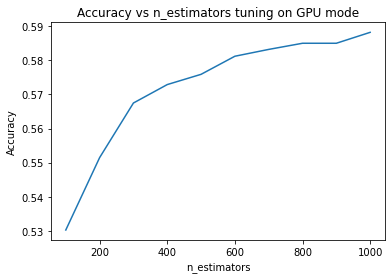

In [ ]:
"""n = 100, accuracy = 0.5303
n = 200, accuracy = 0.5515
n = 300, accuracy = 0.5675
n = 400, accuracy = 0.5729
n = 500, accuracy = 0.5759
n = 600, accuracy = 0.5812
n = 700, accuracy = 0.5832
n = 800, accuracy = 0.585
n = 900, accuracy = 0.585
n = 1000, accuracy = 0.5882"""
n = range(100, 1001, 100)
acc = [0.5303, 0.5515, 0.5675, 0.5729, 0.5759, 0.5812, 0.5832, 0.585, 0.585, 0.5882]
plt.plot(n, acc)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.title('Accuracy vs n_estimators tuning on GPU mode')

Text(0.5, 0.92, 'Accuracy vs max_depth and min_child_weight tuning on GPU mode')

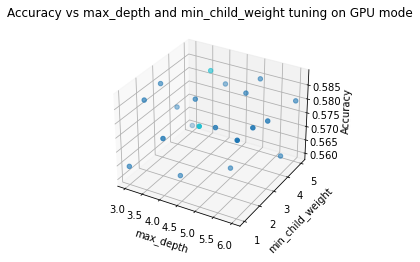

In [ ]:
"""n = 3, m = 1, accuracy = 0.5643 using time = 116.9230604171753
n = 3, m = 2, accuracy = 0.5597 using time = 117.75442910194397
n = 3, m = 3, accuracy = 0.5613 using time = 118.91093945503235
n = 3, m = 4, accuracy = 0.5646 using time = 117.7471866607666
n = 3, m = 5, accuracy = 0.56 using time = 116.68832921981812
n = 4, m = 1, accuracy = 0.5781 using time = 161.08157563209534
n = 4, m = 2, accuracy = 0.5808 using time = 160.42161321640015
n = 4, m = 3, accuracy = 0.582 using time = 158.8535442352295
n = 4, m = 4, accuracy = 0.5717 using time = 157.70028829574585
n = 4, m = 5, accuracy = 0.5792 using time = 155.74963116645813
n = 5, m = 1, accuracy = 0.586 using time = 220.0921425819397
n = 5, m = 2, accuracy = 0.5844 using time = 211.22691917419434
n = 5, m = 3, accuracy = 0.5847 using time = 205.84746265411377
n = 5, m = 4, accuracy = 0.5883 using time = 202.59051060676575
n = 5, m = 5, accuracy = 0.5844 using time = 200.05987167358398
n = 6, m = 1, accuracy = 0.585 using time = 280.39309215545654
n = 6, m = 2, accuracy = 0.5833 using time = 260.8697645664215
n = 6, m = 3, accuracy = 0.5826 using time = 251.55971002578735
n = 6, m = 4, accuracy = 0.5837 using time = 245.55800366401672
n = 6, m = 5, accuracy = 0.5799 using time = 241.21010422706604"""
n = range(3, 7, 1)
m = range(1, 6, 1)
acc = [0.5643, 0.5597, 0.5613, 0.5646, 0.56, 0.5781, 0.5808, 0.582, 0.5717, 0.5792, 0.586, 0.5844, 0.5847, 0.5883, 0.5844, 0.585, 0.5833, 0.5826, 0.5837, 0.5799]
#plot 3D
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.scatter3D(n, m, acc)
ax.set_xlabel('max_depth')
ax.set_ylabel('min_child_weight')
ax.set_zlabel('Accuracy')

# Data for three-dimensional scattered points
zdata = acc
xdata = list(n) * 5
ydata = list(m) * 4
ax.scatter3D(xdata, ydata, zdata, c=np.array(zdata) > 0.585, cmap='tab10');
plt.title('Accuracy vs max_depth and min_child_weight tuning on GPU mode')

Text(0.5, 1.0, 'Accuracy vs gamma tuning on GPU mode')

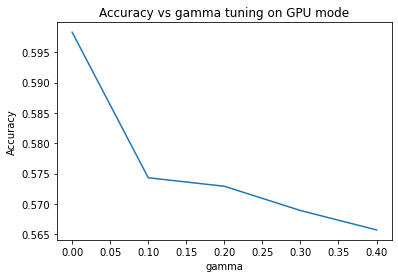

In [ ]:
"""n = 0.0, accuracy = 0.5883 using time = 201.55398797988892
n = 0.1, accuracy = 0.5643 using time = 147.8250710964203
n = 0.2, accuracy = 0.5629 using time = 134.82163071632385
n = 0.30000000000000004, accuracy = 0.5589 using time = 127.59850978851318
n = 0.4, accuracy = 0.5557 using time = 121.74168276786804"""

n = np.arange(0, 0.5, 0.1)
acc = [0.5883, 0.5643, 0.5629, 0.5589, 0.5557]
plt.plot(n, acc)
plt.xlabel('gamma')
plt.ylabel('Accuracy')
plt.title('Accuracy vs gamma tuning on GPU mode')


In [ ]:
"""n = 0.5, m = 0.6, accuracy = 0.5614 using time = 188.0275900363922
n = 0.5, m = 0.7, accuracy = 0.5674 using time = 198.16736483573914
n = 0.5, m = 0.8, accuracy = 0.5698 using time = 205.08549904823303
n = 0.5, m = 0.9, accuracy = 0.562 using time = 212.0228078365326
n = 0.5, m = 1.0, accuracy = 0.5639 using time = 217.33726382255554
n = 0.6, m = 0.6, accuracy = 0.5704 using time = 189.2875418663025
n = 0.6, m = 0.7, accuracy = 0.5693 using time = 196.27089524269104
n = 0.6, m = 0.8, accuracy = 0.5703 using time = 203.32032012939453
n = 0.6, m = 0.9, accuracy = 0.5696 using time = 210.3236861228943
n = 0.6, m = 1.0, accuracy = 0.5723 using time = 215.4000220298767
n = 0.7, m = 0.6, accuracy = 0.5766 using time = 187.9938440322876
n = 0.7, m = 0.7, accuracy = 0.578 using time = 194.90176343917847
n = 0.7, m = 0.8, accuracy = 0.5747 using time = 202.42441296577454
n = 0.7, m = 0.9, accuracy = 0.5752 using time = 209.64375710487366
n = 0.7, m = 1.0, accuracy = 0.5799 using time = 214.8353135585785
n = 0.7999999999999999, m = 0.6, accuracy = 0.5772 using time = 186.0038824081421
n = 0.7999999999999999, m = 0.7, accuracy = 0.5793 using time = 192.76808834075928
n = 0.7999999999999999, m = 0.8, accuracy = 0.5833 using time = 199.71688723564148
n = 0.7999999999999999, m = 0.9, accuracy = 0.5787 using time = 205.9382529258728
n = 0.7999999999999999, m = 1.0, accuracy = 0.5842 using time = 210.4858682155609
n = 0.8999999999999999, m = 0.6, accuracy = 0.5883 using time = 180.6978919506073
n = 0.8999999999999999, m = 0.7, accuracy = 0.584 using time = 187.58838629722595
n = 0.8999999999999999, m = 0.8, accuracy = 0.584 using time = 194.73203802108765
n = 0.8999999999999999, m = 0.9, accuracy = 0.5812 using time = 201.59514808654785
n = 0.8999999999999999, m = 1.0, accuracy = 0.5789 using time = 206.7960352897644
...
n = 0.9999999999999999, m = 0.7, accuracy = 0.5801 using time = 183.66600584983826
n = 0.9999999999999999, m = 0.8, accuracy = 0.5809 using time = 191.28598809242249
n = 0.9999999999999999, m = 0.9, accuracy = 0.5808 using time = 198.175030708313
n = 0.9999999999999999, m = 1.0, accuracy = 0.5883 using time = 202.87825989723206"""

##### try to reduce features

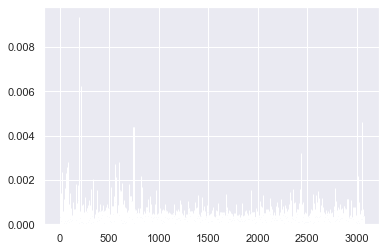

In [ ]:
importanceList = xgb_clf.feature_importances_
plt.bar(range(len(importanceList)), importanceList)
plt.show()

In [ ]:
for batch in range(5):
    x_train = np.concatenate((xs_train_batch[batch-1], xs_train_batch[batch-2], xs_train_batch[batch-3], xs_train_batch[batch-4]))
    y_train = np.concatenate((ys_train_batch[batch-1], ys_train_batch[batch-2], ys_train_batch[batch-3], ys_train_batch[batch-4]))

    reduced_x_train = x_train[:, importanceList > np.percentile(importanceList, 50)]
    reduced_x_val = x_val[:, importanceList > np.percentile(importanceList, 50)]

    xgb_clf.fit(reduced_x_val, y_val)
    print("Using batch {}".format(batch+1))
    print('Test Accuracy: %.5f' % xgb_clf.score(reduced_x_train, y_train))
    print("=====================================")


Using batch 1
Test Accuracy: 0.41408
Using batch 2
Test Accuracy: 0.38303
Using batch 3
Test Accuracy: 0.41218
Using batch 4
Test Accuracy: 0.41430
Using batch 5
Test Accuracy: 0.41373


## Section 3. Your final model. (10 Points)

This is the most important part of this project. You can use all your findings in the experiments above and with other techniques to build your final image classification model. This model will be used to predict the official test set for submission.

In [9]:
xs_train.shape

(50000, 3072)

In [12]:
# === Your code here ===

import time
import xgboost as xgb
from sklearn.metrics import accuracy_score
#if you use HKU CS GPU, you can set the parameter tree_method='gpu_hist', it costs 3 minutes to trian
#if you use Google free GPU, it costs 47 minutes to trian
#otherwise, it costs more than 200 minutes to train


final_model = xgb.XGBClassifier(n_estimators=800, n_jobs=-1, random_state=0, tree_method='gpu_hist', max_depth=5, min_child_weight=4)

# final_model = xgb.XGBClassifier(n_estimators=800, n_jobs=-1, random_state=0, max_depth=5, min_child_weight=4)

start = time.time()
final_model.fit(xs_train, ys_train)
print('Train Accuracy: %.5f' % final_model.score(xs_train, ys_train))
# print time in hh:mm:ss
print("Time taken: ", time.strftime("%H:%M:%S", time.gmtime(time.time() - start)))
# ======================

Train Accuracy: 0.99904
Time taken:  00:47:15


In [13]:
ys_test = final_model.predict(xs_test)

## Section 4. Report your result. (50 Points)

### 4.1. Briefly summarize your experiments. (5 Points)

Write your answers here. You do not need to write a long report, just summarize your designed experiments and the conclusions.

+ We divide data to five batches. Each time we randomly use one batch to do holdout validation.
  
  + if I tune on CS GPU farm, I will use 4 batches to train, 1 batches to valid.

+ Try to do type convert, test whether uint8 affects the result.

+ Tried logistics regression, MLP, SVC at first. Logistics regression is slow and low accuracy compared with SVC. MLP is not good.

+ We tried to use standscaler and minmaxscaler to process data for SVC. StandardScaler seems better.

  - Using PCA to cut down the dimonsion to reduce training time for SVC.

  - tSNE, grayscaler is not good.

+ Tuning the PCA, tuning the SVC and get the key parameters kernel, gamma, C.


+ Testing boosting. Since there are tree based. We will not use scaler. (RF and XGB knows the feature importances, so I didn't use PCA for it)

  - random forest, ada, gradient(so slow not tested), **xgboosting(A powerful boosting I used many times in my kaggle competitions), hist gradient boosting**.

  -  XGBoosting is the best. 0.48 accuracy(use one batch to do hold out validation). 0.58 accuracy(use 4+1 batches to do hold out validation)

    + XGBoosting supports GPU
      + tuning on GPU
    + If using CPU, the final result consumes more than 3 hours.

+ Compare SVC and Hist gradient boosting and XGboosting.

### 4.2. Explain your final solution. (5 Points) 


Write your answers here. You do not need to write a long report, make it clear what is your full pipeline.


Tuning XGBoostClassifier with GPU, otherwise, it is impossible to tuning because CPU runs slowly.

Change the parameter outperforms than default.


We find no need to convert uint8 to float.

__Since XGBoostingClassifier is tree-based, we will not do any standardization or nomarlization.__


1. Import all relative packages, define a xgb_clf with the best parameters.
2. **Train the model with whole train dataset.**
3. Using GPU (4 mins) if available else, using CPU (many hours).
4. Evaluate the training score
5. Print the training time.
6. get the predict y

### 4.3 Submit your predictions on the test set. (40 Points).

We will rank the prediction accuracy for all the submissions. The grading rules will be:

- 40 points for the Top 10%.
- 30 points for the Top 20%.
- 20 points for the Top 50%.
- 10 points for the Top 100%.

Notes:
- Save your predictions on the test set using our code. Do not modify the `save_submission_results()` funciton below. Before submitting your txt file, please check your format is the same as our given file: `pred_0123456789.txt`.
- Zip (1) Your prediction file: `pred_xxxxxx.txt` and (2) `hw3.ipynb` file in a zip file and submit to Moodle.

In [14]:
def save_submission_results(ys_test_pred, uid="WRITE_YOUR_UID_HERE"):
    """
    DO NOT modify this function. Otherwise, our autograder will not
    be able to verify your results.
    
    Args:
        ys_test_pred: numpy array of shape (num_tests, )
        uid: student's UID. 
    """
    num_tests = 10000
    assert isinstance(ys_test_pred, np.ndarray)
    assert ys_test_pred.shape == (num_tests, )
    
    out_path = f"pred_{uid}.txt"
    with open(out_path, "w") as f:
        for idx, y_pred in enumerate(ys_test_pred):
            im_name = f"test_{idx:05d}.jpg"
            f.write(f"{im_name} {y_pred}\n")
    
    print(f"Result written to {out_path}")

In [15]:
# === Your code here ===
# save_submission_results(ys_test_pred, uid="0123456789")
save_submission_results(ys_test, uid="3035772523")
# ======================

Result written to pred_3035772523.txt
